### Introduction
The usage by the Camera team of the LSST Stack for analyzing CCD test data was kicked off by a joint [DM/Camera team workshop](https://confluence.slac.stanford.edu/pages/viewpage.action?spaceKey=LSSTCAM&title=DM+Stack+Working+Meeting) at SLAC, December 10-12, 2012. Even though a lot of the material presented by the DM team is now out-of-date, the [Stack overview talk](https://confluence.slac.stanford.edu/download/attachments/132230065/DM-Tutorial-Stack-Intro-2.pdf?version=1&modificationDate=1355175158000&api=v2) by Mario and Robert's [talk on afw](https://confluence.slac.stanford.edu/download/attachments/132230065/afw-new.pdf?version=1&modificationDate=1355525517000&api=v2) still have useful material that I haven't seen elsewhere.

In this notebook, I'll cover the parts of afw that were used to implement the CCD data analysis code in the [eotest package](https://github.com/lsst-camera-dh/eotest).  Descriptions of those analyses are given in Camera document [LCA-10103](https://docushare.lsst.org/docushare/dsweb/Get/LCA-10103).

There is API-level documentation of the Stack code as [doxygen](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/index.html), including some [how-tos and more detailed descriptions of the interfaces](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/pages.html).

To run this notebook at SLAC, one just needs to source the setup file (from bash) used for the standard analyses of the vendor test data and then enter the `jupyter notebook` command:
```shell
bash$ source /nfs/farm/g/lsst/u1/software/redhat6-x86_64-64bit-gcc44/prod/release/setup.sh
[jh]$ jupyter notebook
```
This will set up v12_0 of the LSST Stack and eotest version 0.0.28.  Alternatively, one can set up v14_0 of the Stack:
```shell
bash$ source /nfs/farm/g/lsst/u1/software/redhat6-x86_64bit-gcc44/DMstack/v14_0/loadLSST.bash
bash$ setup lsst_distrib
bash$ jupyter notebook
```
Note that this installation of v14_0 is python3 and that there are minor interface change between v12_0 and v14_0, as noted below.  In addition, eotest will need to be set up and built against this version of the Stack separately.  Merlin has a pull-request for a python3 and v14_0 compatible branch [here](https://github.com/lsst-camera-dh/eotest/pull/37).

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import lsst.afw.detection as afw_detect
import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
import lsst.afw.math as afw_math

Here are a few functions to display the pixel data. 

In [2]:
def plot_serial(image, row, drow=1, x_range=None, label=None, fmt='-'):
    """Plot a profile slice of the image data in the serial direction."""
    imarray = image.getArray()
    ny, nx = imarray.shape
    plt.errorbar(range(nx), np.sum(imarray[row:row + drow, :], axis=0), fmt=fmt,
                 label=label)
    if x_range is not None:
        axis = list(plt.axis())
        axis[:2] = x_range
        plt.axis(axis)
    plt.xlabel('x (pixel number)')
    plt.ylabel('pixel value (ADU)')

In [3]:
def display_image(image, bbox=None, cmap=plt.cm.gray, grow=0, pix_range=None):
    """Display pixel data within the optional bounding box."""
    if bbox is None:
        bbox = image.getBBox()
    bbox.grow(grow)
    bbox.clip(image.getBBox())
    sub_image = image.Factory(image, bbox)
    display = plt.imshow(sub_image.getArray()[::-1, :], interpolation='nearest', cmap=cmap)
    if pix_range is not None:
        norm = mpl.colors.Normalize(vmin=pix_range[0], vmax=pix_range[1])
        display.set_norm(norm)
    xticks = plt.xticks()[0]
    dx = max(1, int(xticks[1] - xticks[0]))
    yticks = plt.yticks()[0]
    dy = max(1, int(yticks[1] - yticks[0]))
    plt.xticks(range(0, bbox.getWidth(), dx), range(bbox.getMinX(), bbox.getMaxX(), dx))
    plt.yticks(range(0, bbox.getHeight(), dy), range(bbox.getMaxY(), bbox.getMinY(), -dy))
    plt.xlabel('x (pixel number)')
    plt.ylabel('y (pixel number)')
    return sub_image

In [4]:
def get_bbox(keyword, dxmin=0, dymin=0, dxmax=0, dymax=0):
    """
    Parse an NOAO section keyword value (e.g., DATASEC = '[1:509,1:200]') from the
    FITS header and return the corresponding bounding box for sub-image retrieval.
    """
    xmin, xmax, ymin, ymax = [val - 1 for val in eval(keyword.replace(':', ','))]
    bbox = afw_geom.Box2I(afw_geom.Point2I(xmin + dxmin, ymin + dymin),
                          afw_geom.Point2I(xmax + dxmax, ymax + dymax))
    print("bounding box:", bbox)
    return bbox

----
### Estimating the system gain from Fe55 data
- Read in Fe55 data from ITL
- Compute some image statistics
- Subtract the bias level derived from the overscan data, and do a 
  local background estimate and subtraction
- Detect the Fe55 charge clusters
- Compute the cluster fluxes
- Estimate the system gain from the resulting flux distribution

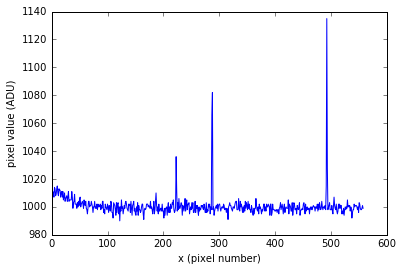

In [5]:
# These are Fe55 data from a recent delivery from ITL.
sensor_id = 'ITL-3800C-368'
image_file = '/nfs/farm/g/lsst/u1/jobHarness/jh_archive/ITL-CCD/ITL-3800C-368/6426/vendorIngest/v0/38604/fe55/20180108110712/ITL-3800C-368_fe55_fe55_001_20180108110712.fits'

# Read in the first image HDU as a Image of floats.
#hdu = 1         # v14_0
hdu = 2         # v12_0
image0 = afw_image.ImageF(image_file, hdu)

# Plot an arbitrary row of data.
plt.figure()
row = 500
plot_serial(image0, row)

bounding box: Box2I((449, 1909), (549, 2009))


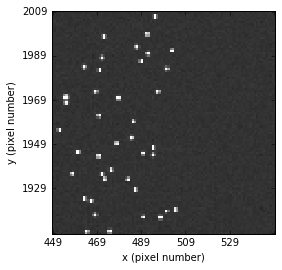

In [6]:
# Display the upper right corner of the segment
subim = display_image(image0, bbox=get_bbox('[450, 550, 1910, 2010]'), pix_range=(950, 1200))

In [7]:
# Statistics operations are performed on masked images.
#mask = afw_image.Mask(image0.getDimensions())    # v14_0
mask = afw_image.MaskU(image0.getDimensions())   # v12_0
mi0 = afw_image.MaskedImageF(image0, mask)

# An optional StatisticsControl object can be used to enable masks to
# omit pixel defects, bad columns, etc..
stat_ctrl = afw_math.StatisticsControl()
#mask_bits = 2**9 - 1      # enable the first 8 masks
#stat_ctrl.setAndMask(mask_bits)

# These are some of the statistics quantities that can be computed with makeStatistics(...).
flags = afw_math.MEDIAN | afw_math.MEAN | afw_math.MEANCLIP | afw_math.STDEV | afw_math.STDEVCLIP

# Read in the FITS header for this extension.
md = afw_image.readMetadata(image_file, hdu)

# Compute statistics for the imaging section.
print("Imaging section statistics:")
imsec = mi0.Factory(mi0, get_bbox(md.get('DATASEC')))
imstats = afw_math.makeStatistics(imsec, flags, stat_ctrl)
print("median:", imstats.getValue(afw_math.MEDIAN))
print("mean:", imstats.getValue(afw_math.MEAN))
print("meanclip:", imstats.getValue(afw_math.MEANCLIP))
print("stdev:", imstats.getValue(afw_math.STDEV))
print("stdevclip:", imstats.getValue(afw_math.STDEVCLIP), '\n')

# Compute statistics for the overscan region.
print("Overscan region statistics:")
oscan = mi0.Factory(mi0, get_bbox(md.get('BIASSEC'), dxmin=5))   # skip the first 5 columns to avoid trailed charge.
ostats = afw_math.makeStatistics(oscan, flags, stat_ctrl)
print("median:", ostats.getValue(afw_math.MEDIAN))
print("mean:", ostats.getValue(afw_math.MEAN))
print("meanclip:", ostats.getValue(afw_math.MEANCLIP))
print("stdev:", ostats.getValue(afw_math.STDEV))
print("stdevclip:", ostats.getValue(afw_math.STDEVCLIP))

Imaging section statistics:
bounding box: Box2I((0, 0), (508, 1999))
median: 1000.0
mean: 1005.3007387
meanclip: 1000.03860837
stdev: 32.8393820948
stdevclip: 3.12040965028 

Overscan region statistics:
bounding box: Box2I((514, 0), (558, 1999))
median: 999.0
mean: 999.380611111
meanclip: 999.384535692
stdev: 2.68454915146
stdevclip: 2.65015649056


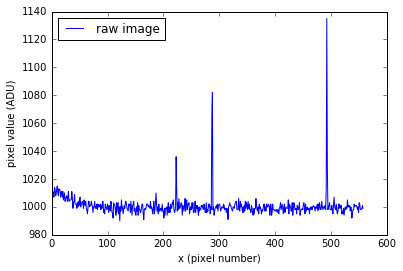

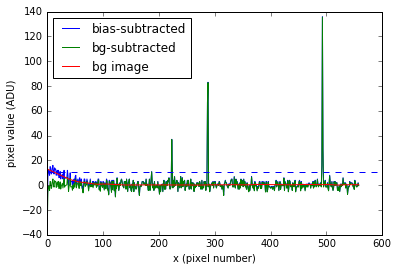

In [8]:
# Perform a bias level subtraction using the median of the overscan region.
bias_level = ostats.getValue(afw_math.MEDIAN)

plot_serial(image0, row, label='raw image')
plt.legend(loc=0)

# Make a deep copy since arthmetic operations modify the underlying pixel data in an Image.
#image_minus_bias = image0.Factory(image0, deep=True)    # v14_0
image_minus_bias = image0.Factory(image0)               # v12_0
image_minus_bias -= bias_level
plt.figure()
plot_serial(image_minus_bias, row, label='bias-subtracted')

# Compute a background image in bg_size x bg_size regions.
# See http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/_background_example.html
bg_size = 16
nx = int(image0.getWidth()//bg_size) + 1
ny = int(image0.getHeight()//bg_size) + 1
bg_ctrl = afw_math.BackgroundControl(nx, ny)
bg_obj = afw_math.makeBackground(image_minus_bias, bg_ctrl)
bg_image = bg_obj.getImageF('LINEAR')

#image = image0.Factory(image_minus_bias, deep=True)    # v14_0
image = image0.Factory(image_minus_bias)               # v12_0
image -= bg_image
plot_serial(image, row, label='bg-subtracted')
plot_serial(bg_image, row, label='bg image')

plt.legend(loc=0)

# Set a 4-sigma threshold for object detection.
threshold_value = 4.*ostats.getValue(afw_math.STDEVCLIP)
plt.axhline(threshold_value, linestyle='--')

In [9]:
# Detected objects are represented as pixel footprints above threshold.
threshold = afw_detect.Threshold(threshold_value)
npix_min = 5
fp_set = afw_detect.FootprintSet(image, threshold, npix_min)

# Grow the footprint by 1 pixel to avoid bias in the fluxes estimated
# by summing over pixel values.
grow = 1
isotropic = False
fp_set_grow = afw_detect.FootprintSet(fp_set, grow, isotropic)

We can use the `display_image` function to inspect these footprints.

[[   7.53067684   41.52229309    2.51391125]
 [  58.55421829  395.54464722   32.53505325]
 [  12.5777607    45.56697845   -2.44380355]]


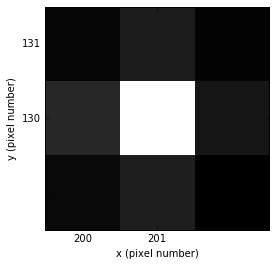

In [10]:
fps = [x for x in fp_set.getFootprints()]
fp = fps[300]
sub_image = display_image(image, fp.getBBox())
print(sub_image.getArray()[::-1, :])

In [11]:
def gain_est(hist, fe55_yield=1590.):
    """
    Estimate the system gain from the peak of the Fe55 flux
    distribution using the Fe55 yield at -100 C.
    """
    index = np.where(hist[0] == max(hist[0]))
    dn = hist[1][index][0]
    return fe55_yield/dn

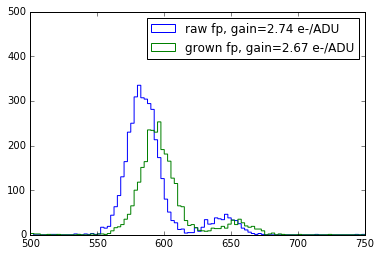

In [12]:
#mask = afw_image.Mask(image.getDimensions())    # v14_0
mask = afw_image.MaskU(image.getDimensions())   # v12_0
mi = afw_image.MaskedImageF(image, mask)

# Compute the flux distributions, using HeavyFootprints to access the pixel values.
bins = 100
x_range = (500, 750)

# Analyze the raw footprints.
fluxes = []
for fp in fp_set.getFootprints():
    heavy_fp = afw_detect.HeavyFootprintF(fp, mi)
    fluxes.append(sum(heavy_fp.getImageArray()))
hist = np.histogram(fluxes, bins, range=x_range)
hist = plt.hist(fluxes, bins=bins, range=x_range, histtype='step',
                label='raw fp, gain=%.2f e-/ADU' % gain_est(hist))

# Analyze the grown footprints.
fluxes_grow = []
for fp in fp_set_grow.getFootprints():
    heavy_fp = afw_detect.HeavyFootprintF(fp, mi)
    fluxes_grow.append(sum(heavy_fp.getImageArray()))
hist_grow = np.histogram(fluxes_grow, bins, range=x_range)
hist_grow = plt.hist(fluxes_grow, bins=bins, range=x_range, histtype='step',
                     label='grown fp, gain=%.2f e-/ADU' % gain_est(hist_grow))

plt.axis((x_range[0], x_range[1], 0.1, 500))
plt.legend(loc=0)

#### Median image generation
A useful afw operation that this Fe55 example does not cover, but which is used by eotest, is the "medianing" of a stack of images:

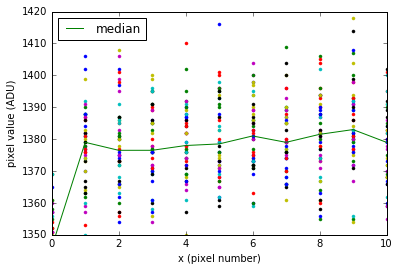

In [13]:
import glob
files = glob.glob('/nfs/farm/g/lsst/u1/jobHarness/jh_archive/ITL-CCD/ITL-3800C-368/6426/vendorIngest/v0/38604/sflat_500/20180108110734/*sflat_500_flat_L*.fits')
images = [afw_image.ImageF(item, hdu) for item in files]
image_vec = afw_image.vectorImageF()
for im in images:
    image_vec.push_back(im)
median_image = afw_math.statisticsStack(image_vec, afw_math.MEDIAN)
for im in images:
    plot_serial(im, row, fmt='.')
plot_serial(median_image, row, label='median', x_range=x_range)
plt.axis((0, 10, 1350, 1420))
plt.legend(loc=0)

----
### Running the eotest code
The above examples use only afw modules from the Stack.  Here we will use the eotest package to do the Fe55 analysis.  A very out-of-date user guide for the eotest package is available [here](https://confluence.slac.stanford.edu/display/LSSTCAM/eotest+User+Manual).

In [14]:
# Do the Fe55 analysis using the eotest code.  
import lsst.eotest.sensor as sensorTest

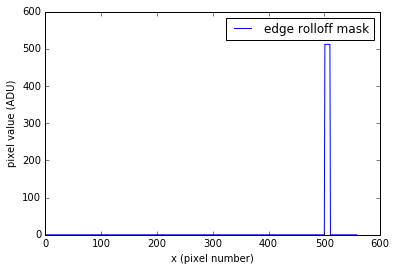

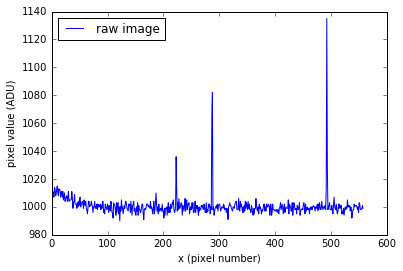

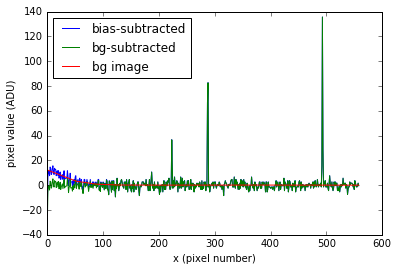

In [15]:
# The main data abstraction in the eotest code is the MaskedCCD class.
# It handles amplifier/pixel geometry and masks automatically.
#
# Various functions and tasks generate mask files, the names of which
# can be passed via a tuple in the constructor.
mask_file = '%s_edge_rolloff_mask.fits' % sensor_id
edge_rolloff_mask = sensorTest.rolloff_mask(image_file, mask_file)
ccd = sensorTest.MaskedCCD(image_file, mask_files=(mask_file,))
ccd.setAllMasks()     # This enables all of the mask bits.

mask = afw_image.ImageI(mask_file, hdu)
plot_serial(mask, row, label='edge rolloff mask')
plt.legend(loc=1)

amp = 1
plt.figure()
plot_serial(ccd[amp].getImage(), row, label='raw image')
plt.legend(loc=0)

plt.figure()
image_minus_bias = ccd.bias_subtracted_image(amp, fit_order=1).getImage()
plot_serial(image_minus_bias, row, label='bias-subtracted')

bg_ctrl = afw_math.BackgroundControl(bg_size, bg_size, ccd.stat_ctrl)
bg_object = afw_math.makeBackground(image_minus_bias, bg_ctrl)
bg_image = bg_object.getImageF('LINEAR')

#image = image_minus_bias.Factory(image_minus_bias, deep=True)    # v14_0
image = image_minus_bias.Factory(image_minus_bias)               # v12_0
image -= bg_image

plot_serial(image, row, label='bg-subtracted')
plot_serial(bg_image, row, label='bg image')
plt.legend(loc=0)

In [16]:
# Various bounding boxes are computed from the FITS header data.
print(ccd.amp_geom.imaging)
print(ccd.amp_geom.serial_overscan)
print(ccd.amp_geom.parallel_overscan)

Box2I((0, 0), (508, 1999))
Box2I((509, 0), (558, 2009))
Box2I((0, 2000), (509, 2009))


In [17]:
# The Fe55Task will fit 2D Gaussians to the raw footprints, thereby estimating both the flux
# and PSF sigma for each charge cluster.  This can take several minutes since it computes
# gains and PSF sigmas for all 16 amplifiers.
task = sensorTest.Fe55Task()
mask_files = ()
task.run(sensor_id, (image_file,), mask_files)

/nfs/farm/g/lsst/u1/software/redhat6-x86_64-64bit-gcc44/DMstack/v12_0/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


{1: 2.6600574881328454,
 2: 2.6556059792428215,
 3: 2.6555889242071227,
 4: 2.6727043692917429,
 5: 2.6593248039503181,
 6: 2.6751874937009861,
 7: 2.6766820752966693,
 8: 2.6594750687834208,
 9: 2.7200704110344316,
 10: 2.7777211839994083,
 11: 2.7857204758377545,
 12: 2.7867135381553503,
 13: 2.8472023582959043,
 14: 2.7726940297344407,
 15: 2.7773994486335902,
 16: 2.7282575370651352}